# FY 2025 Hospital Readmission Predictor (Enhanced Version)
(30-day readmissions, HRRP measures)

*Dataset*: `FY_2025_csv.csv`  
*Target*: `Number of Readmissions`

In [1]:
# Core
import pandas as pd
import numpy as np

# Modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
import shap

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

# Widen display
pd.set_option('display.max_columns', None)

In [2]:
df_raw = pd.read_csv('C:\\Users\\Hp\\Desktop\\MyWorkspaces\\My Analyst Project\\Hospital Data\\data\\csv\\FY_2025_csv.csv')
print(df_raw.shape)
df_raw.head()

(18510, 12)


,Facility Name,Facility ID,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-AMI-HRRP,296.0,NaN,0.9483,13.0146,13.7235,36,07/01/2020,06/30/2023
1,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-CABG-HRRP,151.0,NaN,0.9509,9.6899,10.1898,13,07/01/2020,06/30/2023
2,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-HF-HRRP,681.0,NaN,1.0597,21.5645,20.3495,151,07/01/2020,06/30/2023
3,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-HIP-KNEE-HRRP,NaN,NaN,0.9654,4.2680,4.4211,Too Few to Report,07/01/2020,06/30/2023
4,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-PN-HRRP,490.0,NaN,0.9715,16.1137,16.5863,77,07/01/2020,06/30/2023


In [3]:
def clean(df):
    """Minimal cleaning pipeline."""
    df = df.copy()

    # Drop rows where target is missing
    df = df[df['Number of Readmissions'].notna()]

    # Convert 'Too Few to Report' → NaN in numeric columns
    numeric_cols = ['Excess Readmission Ratio', 'Predicted Readmission Rate',
                    'Expected Readmission Rate', 'Number of Discharges',
                    'Number of Readmissions']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Fill remaining NaNs
    df['Footnote'] = df['Footnote'].astype('category')
    df['Measure Name'] = df['Measure Name'].astype('category')
    df['Facility Name'] = df['Facility Name'].astype('category')
    df['State'] = df['State'].astype('category')
    
    # Ensure no NaNs in the target column
    df = df.dropna(subset=['Number of Readmissions'])
    
    return df

df = clean(df_raw)
print("Rows after cleaning:", df.shape[0])

Rows after cleaning: 8121


In [4]:
TARGET = 'Number of Readmissions'

# Columns we DO NOT want as predictors
non_features = [TARGET, 'Start Date', 'End Date', 'Footnote', 'Facility Name', 'Facility ID']

y = df[TARGET]
X = df.drop(columns=non_features)

# Identify column types
cat_cols = ['State', 'Measure Name']
num_cols = [c for c in X.columns if X[c].dtype != 'category' and c not in cat_cols]

# Add interaction terms
X['Excess_Ratio_x_Discharges'] = X['Excess Readmission Ratio'] * X['Number of Discharges']
num_cols.append('Excess_Ratio_x_Discharges')

In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

model = RandomForestRegressor(random_state=42, n_jobs=-1)

pipe = Pipeline(steps=[('prep', preprocessor),
                      ('clf', model)])

param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

search = RandomizedSearchCV(pipe, param_grid, n_iter=10, cv=5, scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1)
search.fit(X, y)

print("Best parameters found: ", search.best_params_)

Best parameters found:  {'clf__n_estimators': 300, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_depth': None}


In [6]:
best_model = search.best_estimator_

cv = KFold(n_splits=5, shuffle=True, random_state=42)
neg_mae = cross_val_score(best_model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae = -neg_mae
print("Mean Absolute Error (5-fold):", mae.mean().round(2))
print("Std:", mae.std().round(2))

Mean Absolute Error (5-fold): 0.92
Std: 0.09


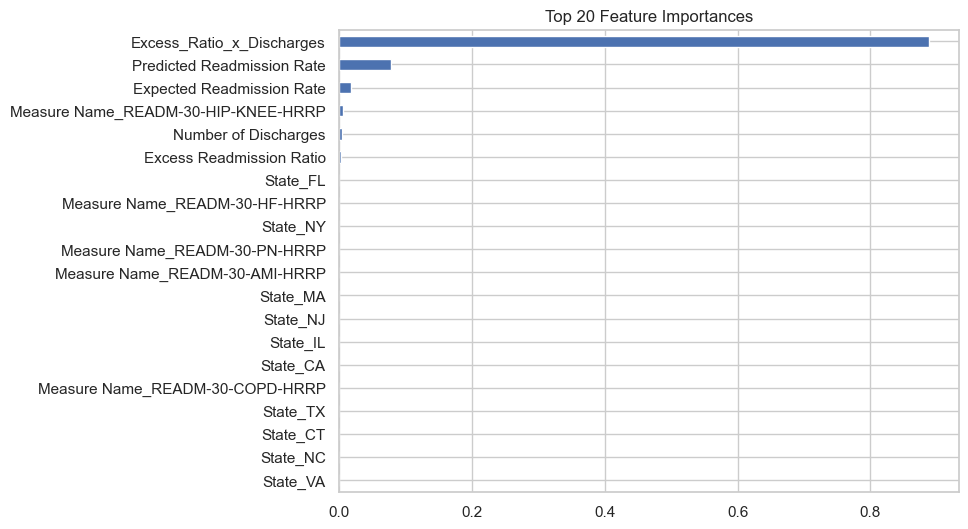

In [7]:
best_model.fit(X, y)

# Pull out feature names after one-hot encoding
ohe = best_model.named_steps['prep'].named_transformers_['cat']
cat_features = ohe.get_feature_names_out(cat_cols)
all_features = num_cols + list(cat_features)

importances = best_model.named_steps['clf'].feature_importances_
feat_df = pd.Series(importances, index=all_features).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feat_df.head(20).plot(kind='barh')
plt.title("Top 20 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [8]:
# Example dummy row
new_row = {
    'State': 'CA',
    'Measure Name': 'READM-30-HF-HRRP',
    'Excess Readmission Ratio': 1.05,
    'Predicted Readmission Rate': 20.0,
    'Expected Readmission Rate': 19.0,
    'Number of Discharges': 500,
    'Excess_Ratio_x_Discharges': 1.05 * 500
}

new_df = pd.DataFrame([new_row])
pred = best_model.predict(new_df)
print("Predicted # readmissions:", int(pred[0]))

Predicted # readmissions: 102


In [9]:
# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

# Define the model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Define the pipeline
xgb_pipe = Pipeline(steps=[('prep', preprocessor),
                           ('clf', xgb_model)])

# Define the parameter grid
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.1, 0.2]
}

# Perform RandomizedSearchCV
xgb_search = RandomizedSearchCV(xgb_pipe, param_grid, n_iter=10, cv=5, scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1)
xgb_search.fit(X, y)

print("Best parameters found: ", xgb_search.best_params_)

Best parameters found:  {'clf__n_estimators': 300, 'clf__max_depth': 7, 'clf__learning_rate': 0.1}


In [10]:
best_xgb_model = xgb_search.best_estimator_

cv = KFold(n_splits=5, shuffle=True, random_state=42)
neg_mae = cross_val_score(best_xgb_model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae = -neg_mae
print("Mean Absolute Error (5-fold):", mae.mean().round(2))
print("Std:", mae.std().round(2))

Mean Absolute Error (5-fold): 1.15
Std: 0.2


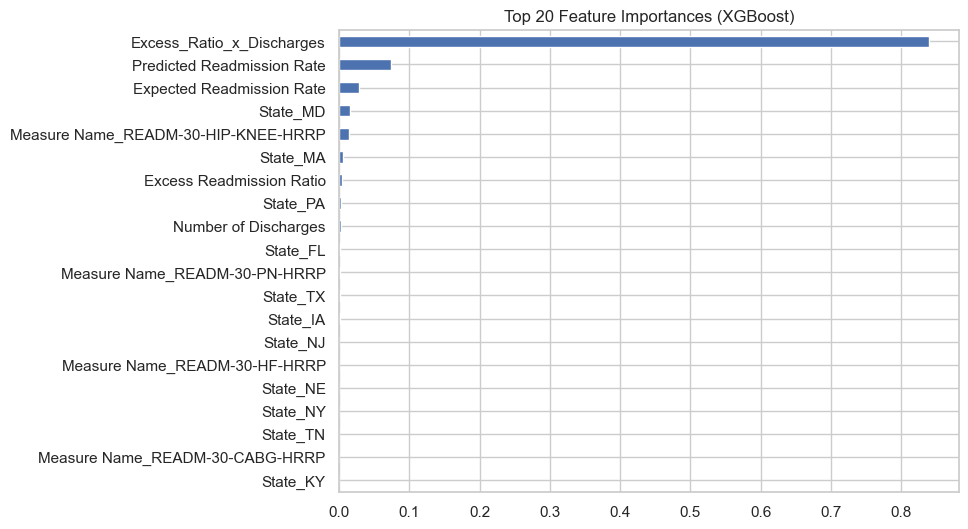

In [11]:
best_xgb_model.fit(X, y)

# Pull out feature names after one-hot encoding
ohe = best_xgb_model.named_steps['prep'].named_transformers_['cat']
cat_features = ohe.get_feature_names_out(cat_cols)
all_features = num_cols + list(cat_features)

importances = best_xgb_model.named_steps['clf'].feature_importances_
feat_df = pd.Series(importances, index=all_features).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feat_df.head(20).plot(kind='barh')
plt.title("Top 20 Feature Importances (XGBoost)")
plt.gca().invert_yaxis()
plt.show()

100%|===================| 8087/8121 [03:19<00:00]        

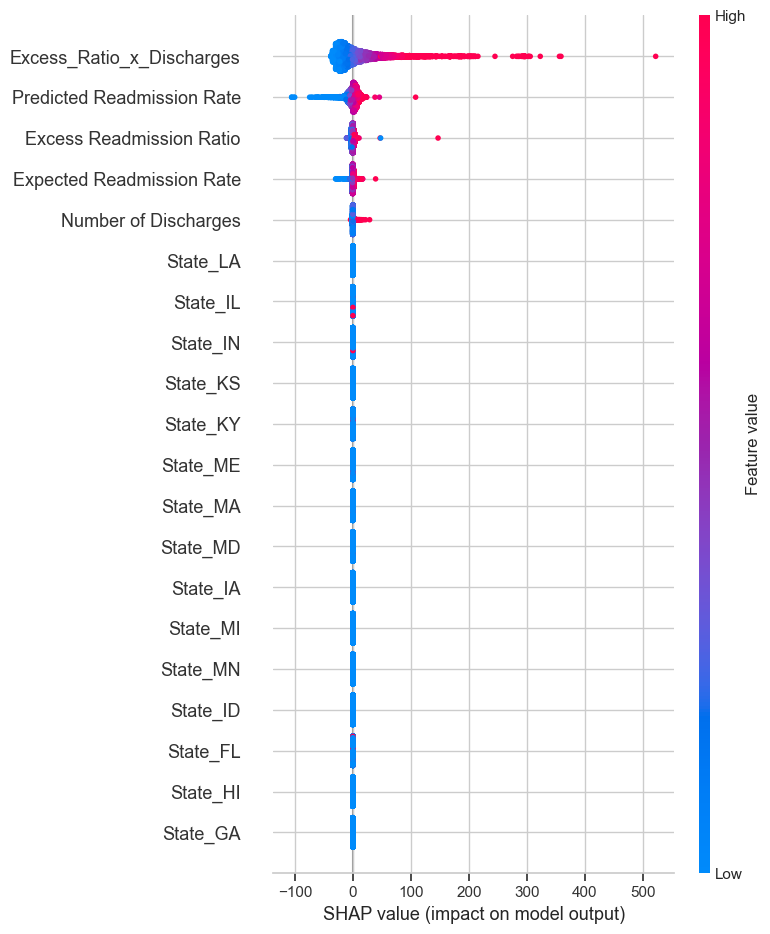

In [15]:
# Fit the best XGBoost model
best_xgb_model.fit(X, y)

# Transform the data using the preprocessor
X_transformed = best_xgb_model.named_steps['prep'].transform(X)

# Convert the transformed data to a dense array if it is sparse
if isinstance(X_transformed, pd.DataFrame):
    X_transformed_df = X_transformed
else:
    X_transformed_df = pd.DataFrame(X_transformed.toarray(), columns=all_features)

# Calculate SHAP values
explainer = shap.Explainer(best_xgb_model.named_steps['clf'], X_transformed_df)
shap_values = explainer(X_transformed_df)

# Summary plot
shap.summary_plot(shap_values, X_transformed_df)